In [1]:
 
import yaml 
import numpy as np
import cv2
import matplotlib.pyplot as plt 
from matplotlib.colors import LightSource
import pylab
from IPython.display import clear_output
from models import *
from experiments.vae_experiment import VAEXperiment
from experiments.vae_pix2pix_exp import Pix2pixExperiment 
from torch.utils.data import DataLoader 
from terrain_loader import TerrainDataset 

In [3]:

with open("configs/test.yml", 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(".\n\n",exc)

In [4]:
#Vae Model
vae_model = vae_models[config['vae_model_params']['name']](**config['vae_model_params'])

# pix2pix model
gen_model = pix2pix_model[config['pix2pix_model_params']['gen_name']](config['exp_params']['in_channels'],config['exp_params']['out_channels'])
disc_model = pix2pix_model[config['pix2pix_model_params']['disc_name']](config['exp_params']['in_channels'])


In [5]:
# VAE-FeatureGAN 1
# ! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VanillaVAE/version_0  /scratch/shan/
# ! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VAE_PIX2PIX/version_3 /scratch/shan

In [6]:
if config['vae_model_params']['load_model'] :
    experiment_p2p = Pix2pixExperiment.load_from_checkpoint(config['pix2pix_model_params']['pretrained_model'], gen_model=gen_model,disc_model=disc_model,vae_model=vae_model,params=config['exp_params'])
    experiment_vae = VAEXperiment.load_from_checkpoint(config['vae_model_params']['pretrained_model'], vae_model=vae_model,params=config['exp_params'])
    print("[INFO] Loaded pretrained model")

[INFO] Loaded pretrained model


In [7]:
vae_model.eval()
gen_model.eval()

Generator(
  (down1): DownSample(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.3, inplace=True)
    )
  )
  (down2): DownSample(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.3, inplace=True)
    )
  )
  (down3): DownSample(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.3, inplace=True)
    )
  )
  (down4): DownSample(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

In [8]:
def denormalize(result):
        # minv, maxv = torch.min(result), torch.max(result)
        new = (result+1)*127.5
        return torch.squeeze(new).detach().numpy().transpose((1,2,0)).astype(np.uint8)


In [9]:
def display(ip, op, val=None):
    res = vae_model(ip)[0]  
    vae_res = torch.squeeze( res*255).detach().numpy().transpose((1,2,0)).astype(np.uint8)
    
    
    res = gen_model(res) 
    res = denormalize(res)
    # res = cv2.GaussianBlur(res,(7,7),0)
    ls = LightSource(azdeg=315, altdeg=45)
    cmap = plt.cm.gist_earth
        
    op = denormalize(op) 
    ip = (ip*255)
    ip = torch.squeeze(ip).detach().numpy().transpose((1,2,0)).astype(np.uint8)
     
    ip = cv2.cvtColor(ip, cv2.COLOR_RGB2BGR)
    vae_res = cv2.cvtColor(vae_res, cv2.COLOR_RGB2BGR)


    display_list = [ip,vae_res,res,op]
    title = ['Input image','VAE Output','Predicted_image','Ground_Truth']
    plt.figure(figsize=(15,15))

    for i in range(2):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i],cmap='gray')
        plt.axis('off')


    plt.subplot(1, 4, 3)

    plt.imshow(ls.hillshade(res[:,:,0],vert_exag=1,dy=10,dx=10), cmap='gray')
    rgb = ls.shade(res[:,:,0], cmap=cmap, blend_mode='overlay' ,vert_exag=1)
    plt.imshow(rgb)
    plt.axis("off")

    plt.subplot(1, 4, 4)

    plt.imshow(ls.hillshade(op[:,:,0],vert_exag=1,dy=10,dx=10), cmap='gray')
    rgb = ls.shade(op[:,:,0], cmap=cmap, blend_mode='overlay' ,vert_exag=1)
    plt.imshow(rgb)
    plt.axis("off")

    # cv2.imwrite("./test_sat_img/vae_op/"+val.split('.')[0]+"ip.png",ip) 
    # cv2.imwrite("./test_sat_img/vae_op/"+val,vae_res) 
    cv2.imwrite("./inp_"+val,ip)
    cv2.imwrite("./int_"+val,vae_res)
    cv2.imwrite("./gt_"+val,op)
    cv2.imwrite("./res_"+val,res) 


 


In [10]:
# img = cv2.imread("./samples/test.png") 
# img = cv2.resize(img,(256,256))
# test = np.zeros((256,512,3))
# test[:,:256,:] = img

# cv2.imwrite("./test/test.png",test)

dataset = TerrainDataset(root = "./",
                        train=False,
                        hide_green=config['exp_params']['hide_green'],
                        norm=config['exp_params']['norm'])

sample_dataloader = DataLoader(dataset,
                        batch_size= 1,
                        num_workers=config['exp_params']['n_workers'],
                        shuffle = True,
                        drop_last=False)


1


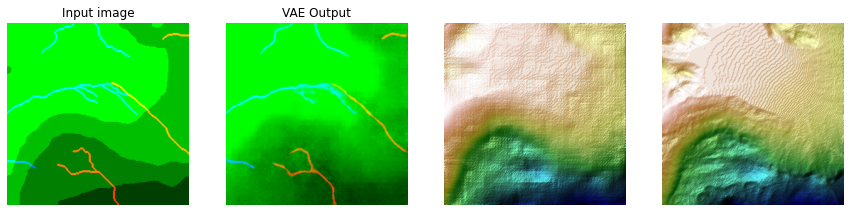

In [11]:
count=0
for ip, op,f in sample_dataloader: 
    display(ip,op,f[0].split('/')[-1])
    
    count+=1 
    break

print(count)

In [ ]:
def display_multiple(ip, op,f): 
    display(ip,op,f)

    plt.figure(figsize=(20,10))

    mu,var = vae_model.encode(ip)
    ls = LightSource(azdeg=315, altdeg=45)
    cmap = plt.cm.gist_earth
    # cmap = plt.cm.RdYlGn
    fig = plt.figure(figsize=(20,15))

    for i in range(5):
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        z = eps * 0.5 + mu
        res = vae_model.decode(z) 
        vae_res = torch.squeeze( res*255).detach().numpy().transpose((1,2,0)).astype(np.uint8)
    
    
        res = gen_model(res) 
        res = denormalize(res)

        
        ax = fig.add_subplot(3, 5, i+1) 
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(vae_res,cmap='gray')
        plt.axis('off')
        
         
        ax = fig.add_subplot(3, 5, i+6)  
         
        res = cv2.GaussianBlur(res, (7, 7), 0)

        ax.imshow(ls.hillshade(res[:,:,0],vert_exag=1,dy=10,dx=10), cmap='gray')
        rgb = ls.shade(res[:,:,0], cmap=cmap, blend_mode='overlay' ,vert_exag=1)
        ax.imshow(rgb)
        ax.axis("off")

    
        cv2.imwrite("./test_sat_img/vae_"+str(i+1)+f,vae_res) 
        cv2.imwrite("./test_sat_img/dem_"+str(i+1)+f,res) 

        

    plt.show()

 



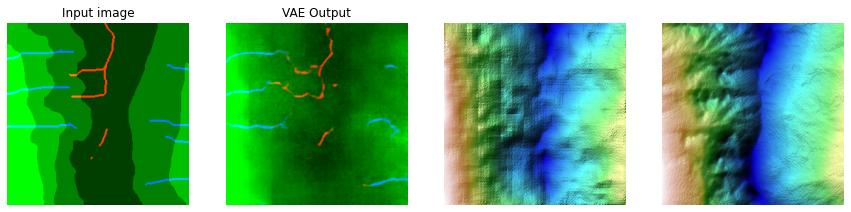

<Figure size 1440x720 with 0 Axes>

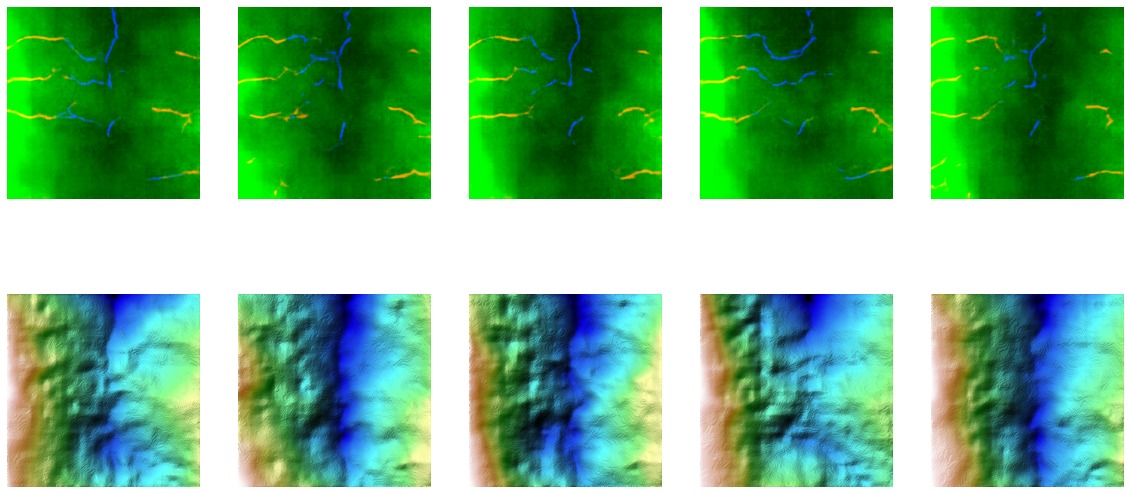

In [ ]:
for ip, op,f in sample_dataloader:
    display_multiple(ip,op,f[0].split('/')[-1] )
    
    break

In [ ]:
def display_interpolation(ip1,op1,ip2,op2,f1,f2):
    display(ip1,op1,f1)
    display(ip2,op2,f2)

    plt.figure(figsize=(20,10))
    ls = LightSource(azdeg=315, altdeg=45)
    cmap = plt.cm.gist_earth

    mu1,var1 = vae_model.encode(ip1)
    mu2,var2 = vae_model.encode(ip2)
    std1 = torch.exp(0.5 *  var1)
    eps1 = torch.randn_like(std1)
    z1 = eps1 * std1 + mu1

    std2 = torch.exp(0.5 *  var2)
    eps2 = torch.randn_like(std2)
    z2 = eps2 * std2 + mu2

    # for i in range(4):
    ratios = np.linspace(0, 1, num=8)
    vectors = []

    for ratio in ratios:
        
        v = (1.0 - ratio) * z1  + ratio * z2
        vectors.append(v)

    images = [] 

    for j,v in enumerate(vectors):
       logits = vae_model.decode(v)
       images.append(logits)
    print(len(images))

    for i,j in enumerate(images):
        vae_res = torch.squeeze(j*255).detach().numpy().transpose((1,2,0)).astype(np.uint8)

        # res = res*2-1
        res=j
        res = gen_model(res) 
        res = denormalize(res)

        plt.subplot(2, 8, i+1) 
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(vae_res,cmap='gray')
        plt.axis('off')
        
        
        plt.subplot(2, 8, i+9) 
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(res,cmap='gray')
        plt.axis('off')
        res = cv2.GaussianBlur(res, (7,7), 0)
        plt.imshow(ls.hillshade(res[:,:,0],vert_exag=1,dy=10,dx=10), cmap='gray')
        rgb = ls.shade(res[:,:,0], cmap=cmap, blend_mode='overlay' ,vert_exag=1)
        plt.imshow(rgb)
        plt.axis("off")
        
        
        cv2.imwrite("./test_sat_img/vae_"+str(i+1)+f1,vae_res) 
        cv2.imwrite("./test_sat_img/dem_"+str(i+1)+f1,res)






    plt.show()






    

In [ ]:
def interpolation(ip1,op1,ip2,op2,f1,f2):
    display(ip1,op1,f1)
    display(ip2,op2,f2)
 
    ls = LightSource(azdeg=315, altdeg=45)
    cmap = plt.cm.gist_earth

    mu1,var1 = vae_model.encode(ip1)
    mu2,var2 = vae_model.encode(ip2)
    std1 = torch.exp(0.5 *  var1)
    eps1 = torch.randn_like(std1)
    z1 = eps1 * std1 + mu1

    std2 = torch.exp(0.5 *  var2)
    eps2 = torch.randn_like(std2)
    z2 = eps2 * std2 + mu2

    # for i in range(4):
    ratios = np.linspace(0, 1, num=2)
    vectors = []

    for ratio in ratios:
        
        v = (1.0 - ratio) * z1  + ratio * z2
        vectors.append(v)

    images = [] 

    for j,v in enumerate(vectors):
       logits = vae_model.decode(v)
       images.append(logits)
    print(len(images))

    for i,j in enumerate(images):
         
        res=j
        res = gen_model(res) 
        res = denormalize(res)
        res = cv2.GaussianBlur(res, (7,7), 0)

        
        rgb = ls.shade(res[:,:,0], cmap=cmap, blend_mode='overlay' ,vert_exag=1)
        plt.figure(figsize=(20,20))
        plt.imshow(rgb)
        plt.axis('off')
        pylab.savefig("../test_sat_img/interpolation/for_video/text_"+str(i+1)+f1, bbox_inches='tight', pad_inches= 0)
        clear_output()
         
        
        cv2.imwrite("../test_sat_img/interpolation/for_video/res"+str(i+1)+f1,res) 
        






    plt.show()






    

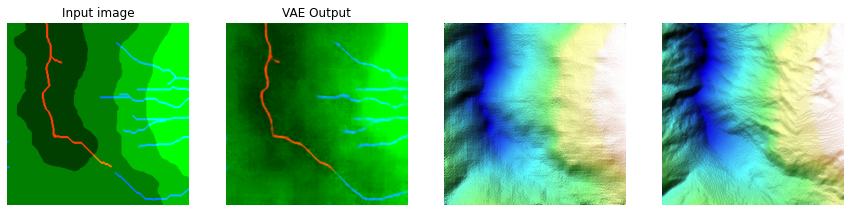

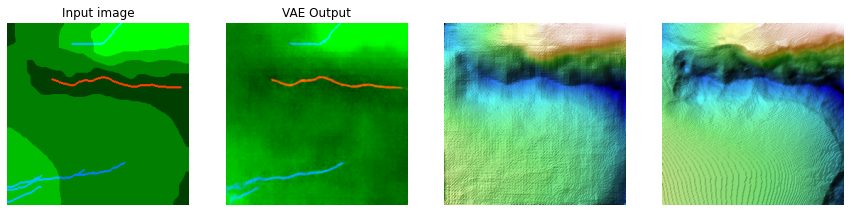

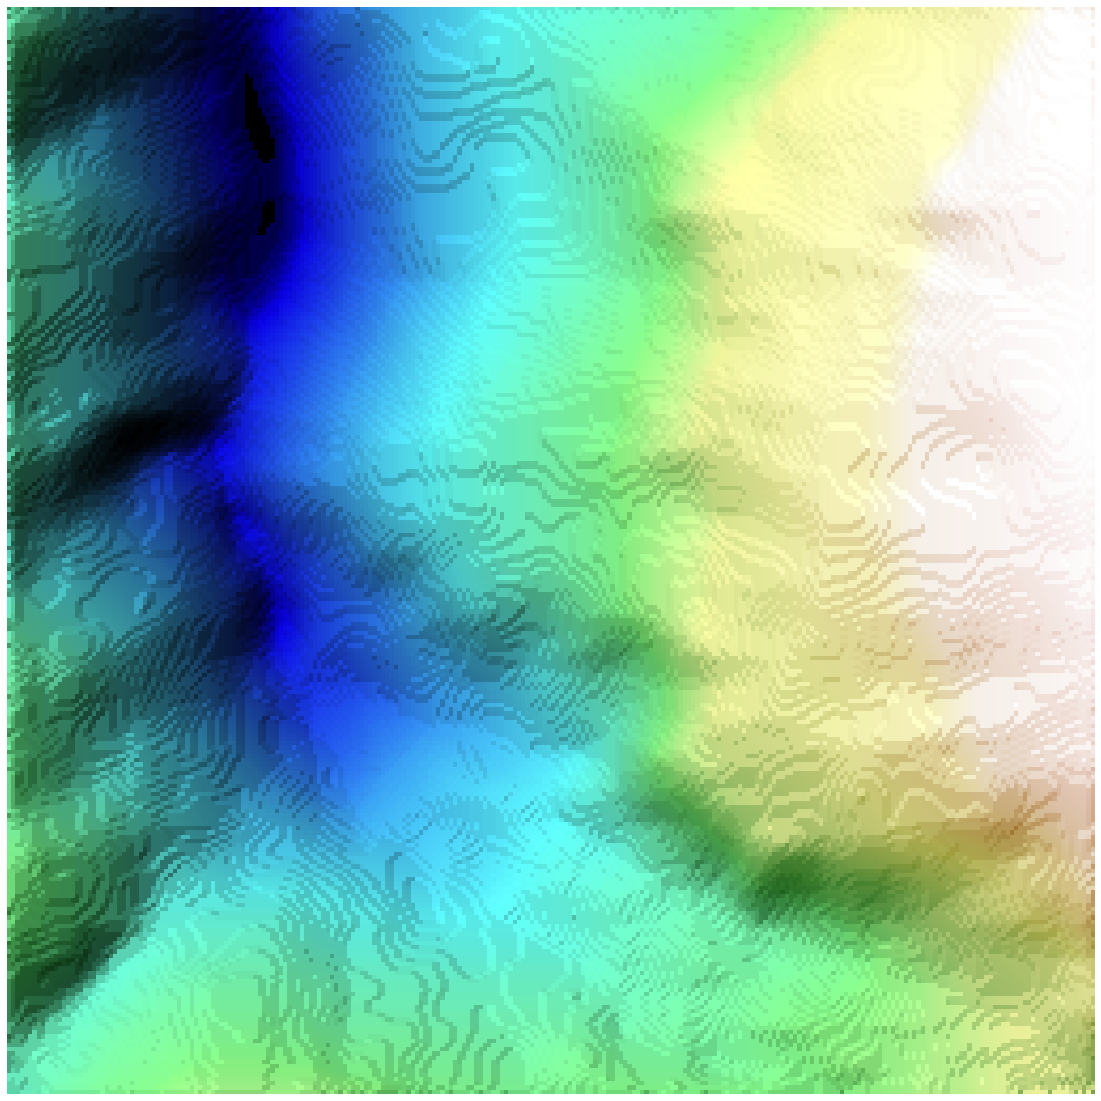

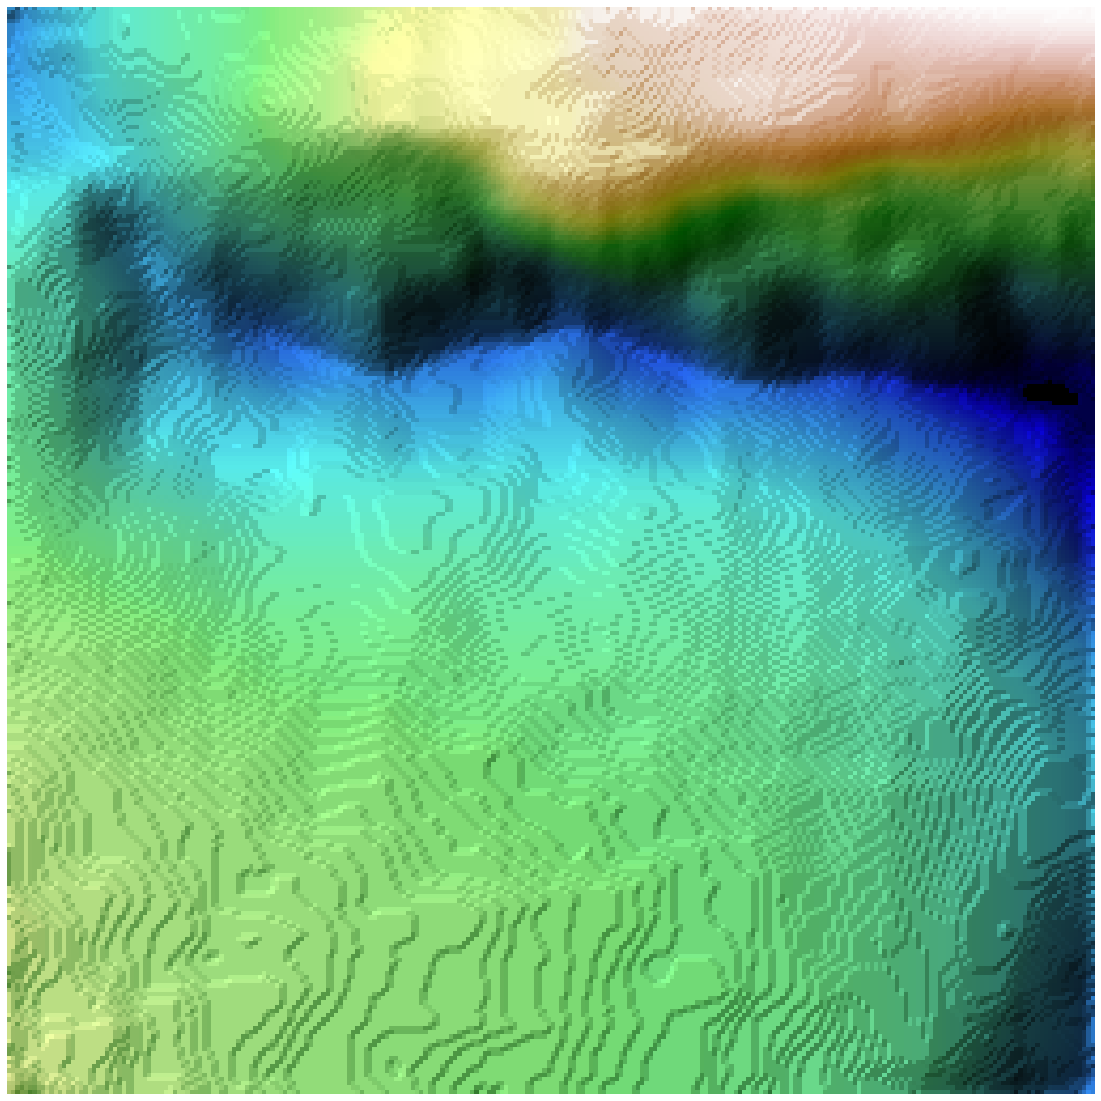

In [ ]:
sample_dataloader_2 = DataLoader(dataset,
                        batch_size= 10,
                        num_workers=config['exp_params']['n_workers'],
                        shuffle = True,
                        drop_last=False)

for ip, op,f in sample_dataloader_2: 
    ip1 = torch.unsqueeze(ip[0], 0)
    ip2 = torch.unsqueeze(ip[1], 0)
    

    op1 = torch.unsqueeze(op[0], 0)
    op2 = torch.unsqueeze(op[1], 0)
    
    f1 = f[0].split('/')[-1]
    f2 = f[1].split('/')[-1]

     

    interpolation(ip1,op1,ip2,op2,f1,f2)
    
    break